<a href="https://colab.research.google.com/github/XuguangAi/BMI733/blob/main/AskReddit_BERT_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

In [2]:
!pip install -q tf-models-official

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
file_path='/content/NLP_Project.zip'
def unzip_data(file_path):
  from zipfile import ZipFile
  with ZipFile(file_path, "r") as zip:
    zip.extractall()
    return "Data has been extracted"

unzip_data(file_path)

'Data has been extracted'

In [5]:
dataset_dir = '/content/NLP_Project'

train_dir = '/content/NLP_Project/train'

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/NLP_Project/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 15997 files belonging to 2 classes.
Using 12798 files for training.
Found 15997 files belonging to 2 classes.
Using 3199 files for validation.
Found 4000 files belonging to 2 classes.


In [7]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [9]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [29]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [30]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6004412]], shape=(1, 1), dtype=float32)


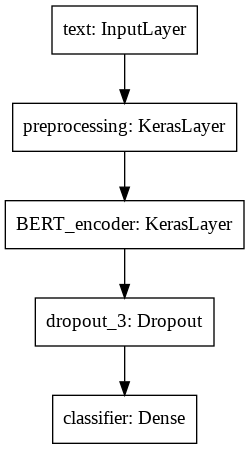

In [31]:
tf.keras.utils.plot_model(classifier_model)

In [36]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.PrecisionAtRecall(0.5, name='F1')
]


In [37]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [38]:
classifier_model.compile(optimizer=optimizer,
                         loss='binary_crossentropy',
                         metrics=METRICS)

In [39]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/5
400/400 [==============================] - 250s 599ms/step - loss: 0.6291 - accuracy: 0.6381 - precision: 0.6246 - recall: 0.6895 - F1: 0.6586 - val_loss: 0.6007 - val_accuracy: 0.6696 - val_precision: 0.6120 - val_recall: 0.9372 - val_F1: 0.7410
Epoch 2/5
400/400 [==============================] - 237s 593ms/step - loss: 0.5145 - accuracy: 0.7384 - precision: 0.7176 - recall: 0.7848 - F1: 0.8033 - val_loss: 0.6081 - val_accuracy: 0.7083 - val_precision: 0.6633 - val_recall: 0.8533 - val_F1: 0.7755
Epoch 3/5
400/400 [==============================] - 237s 592ms/step - loss: 0.3637 - accuracy: 0.8365 - precision: 0.8205 - recall: 0.8607 - F1: 0.9265 - val_loss: 0.7084 - val_accuracy: 0.7143 - val_precision: 0.6659 - val_recall: 0.8670 - val_F1: 0.7670
Epoch 4/5
400/400 [==============================] - 236s 591ms/step - loss: 0.2377 - accuracy: 0.9040 - precision: 0.8933 - recall: 0.9174 - F1: 

In [40]:
classifier_model.evaluate(test_ds)

125/125 [==============================] - 27s 213ms/step - loss: 0.8826 - accuracy: 0.7253 - precision: 0.7136 - recall: 0.7525 - F1: 0.7778


[0.882628858089447,
 0.7252500057220459,
 0.7136083245277405,
 0.7524999976158142,
 0.7777777910232544]

In [42]:
questions = [
    'What is slowly dying off or disappearing?',
    'What happens when neither parent wants the kids in a divorce?',
    'What’s something that fits the script of “less is more”?',
    'What’s your favorite song or band?'
]
classifier_model.predict(questions)

array([[0.99081904],
       [0.0393296 ],
       [0.3001601 ],
       [0.00550563]], dtype=float32)